In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timeit
import rasterio as rio
from tools_AA_IR import get_tif, reading_gps_file
from tools_AA import slice_raw, path_sonde
from tools_EL import readingtemp
from rasterio.plot import plotting_extent
from rasterio.plot import show
from numba import jit

`pip install numba` dans le cas où on veut utiliser l'optimisation

In [85]:
@jit(nopython=True, cache = True)
def alternate_variogram_compiled(X,Y,Z,width,leng,direction = 45,theta_tolerance = 22.5) :
    n=len(X)
    nlag=np.int((leng/width)) # nombre de lag généré
    dist=[]
    for kk in np.arange(0,nlag,1):# pré-allocation des valeurs de distance pour chaque lag
        dist.append(width+width*(kk)) 
    
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag)   
    n=len(X)
    #theta_tolerance = 22.5
    #direction       = 45

    for ii in np.arange(0,n): # boucle sur toutes les valeurs
        print(" ii :",ii, "/",n)
        for jj in np.arange(0,n): # 2nd boucle sur toutes les valeurs
            xi=X[ii]
            yi=Y[ii]
            zi=Z[ii]
            xj=X[jj]
            yj=Y[jj]
            zj=Z[jj]
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360° au lieu de [0-180;-180-0]
            
            if(r<leng) and zi != np.nan and zj != np.nan :
                
                # Ajout de la directionalité 
                if (direction + theta_tolerance) < 360 :
                    if (tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance)) :
                        index=np.int((r/width))  # chaque distance/width est associée à un lag
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                        
                elif (direction + theta_tolerance) > 360 :   
                    if tht >= (direction) or tht <= (0 + (theta_tolerance-(360-direction))) :
                        index=np.int((r/width)) 
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index=np.int((r/width))
                        dev[index]=dev[index]+(zi-zj)**2 
                        counts[index]=counts[index]+1
            
    gam = np.divide(dev,2*counts)
        
    return dist, counts, gam
    

In [94]:
def direction_angle_test(X,Y,Z, INDICE,width,leng,direction = 45,theta_tolerance = 22.5) :
    """
    Permet de tester et voir les valeurs choisient en fonction de la direction +/- angle de tolérance
    """
    n=len(X)
    nlag=np.int(np.fix(leng/width)) # 25, nombre de lag généré, fix : "Round to nearest integer towards zero"
    dist=[]
    for kk in np.arange(0,nlag,1): # génération de point 0:1:nlag
        dist.append(width+width*(kk)) # pré-allocation des valeurs de distance pour chaque lag
        
    leng=dist[nlag-1] # distance maximale, valeur du dernier lag
    dev=np.zeros(nlag)
    counts=np.zeros(nlag);    
    theta = []
    #theta_tolerance = 22.5
    #direction       = 45
    index_dict = {}
    
    for ii in [INDICE]:
        index = []
        for jj in np.arange(0,n): 
            xi=X[ii] # xi
            yi=Y[ii]
            zi=Z[ii] # Zi, Observation value
            xj=X[jj] # xi+h, h = distance lag
            yj=Y[jj]
            zj=Z[jj] # Zi+h
            
            x = xj-xi
            y = yj-yi
            r   = np.sqrt((x)**2+(y)**2) # distance euclidienne
            tht = np.arctan2(y,x) * (180/np.pi)
            
            if tht < 0 :
                tht = 180 + 180-np.absolute(tht) # permet de varier de 0° -> 360°
            
            if(r<leng):
                # Ajout de la direction 
                
                if (direction + angle_tolerance) < 360 :
                    if (tht >= (direction - theta_tolerance)) and (tht <= (direction + theta_tolerance)) :
                        index.append(jj)
                        
                elif (direction + angle_tolerance) > 360 : 
                    if tht >= (direction) or tht <= (0 + (angle_tolerance-(360-direction))) :
                        index.append(jj)
                else :
                    if (tht >= (360 - np.absolute(theta_tolerance - direction ))) or (tht <= (direction  + theta_tolerance)):
                        index.append(jj)
                    
        index_dict[ii] = index
            
    return index_dict
    

In [3]:
def reading_all_IR(filetif,ls_path_tif) :
    for path_tif in ls_path_tif :
        with rio.open(path_tif) as dataset :
            st1 = timeit.default_timer()

            all_band= dataset.read(1)
            win_transform = dataset.transform
            extent = plotting_extent(all_band,win_transform)
            width  = dataset.width
            height = dataset.height

            x_start = win_transform[2]
            x_res   = win_transform[0]
            x_end   = x_start+(float(x_res)*dataset.width)

            y_end   = win_transform[5]
            y_res   = win_transform[4]
            y_start = y_end + (float(y_res)*dataset.height)

            x = np.linspace(x_start,x_end,num = width)
            x = x[0:-2] # Permet de supprimer la dernière value incorrecte ?  
            y = np.linspace(y_start,y_end,num = height)
            y = y[0:-2] # Permet de supprimer la dernière value incorrecte ? 
            band_1 = []
            x_matrix = []
            y_matrix = []
            for ii in range(len(x)) :
                # Petit timer pour observer l'avancée
                if ii in [len(x)/2,len(x)/3,len(x)/4,len(x)/5,len(x)/6,len(x)/10] : 
                    st2 = timeit.default_timer()
                    # print("ii :", ii ,"RUN TIME : {0}".format(st2-st1))
                    
                for jj in range(len(y)) :
                    for val in dataset.sample([(x[ii],y[jj])]): 
                        band_1.append(float(val))
                        x_matrix.append(x[ii]) # permet de répeter le terme 
                        y_matrix.append(y[jj])
                        mapping = ['x','y','band 1']
                st3 = timeit.default_timer()
                        
        DATA_WINDOW = pd.DataFrame(np.array([x_matrix,
                                             y_matrix,
                                             band_1],dtype = float).T,
                                   columns=mapping)
            
        DATA_WINDOW["band 1"] = DATA_WINDOW["band 1"].replace(1.0,np.NAN)
        DATA_WINDOW = DATA_WINDOW.dropna()

    return DATA_WINDOW

        

In [18]:
def dict_temp_sensor_function(date_1,date_2) :
    """
    fonction créant un dictionnaire regroupant les DATAFRAMES tronquées aux dates souhaitées 
    """
    
    ls_path = path_sonde()
    dict_temp_sensor = {}
    for i,ls_path_sonde in enumerate(ls_path):
        name = ls_path_sonde[0][ls_path_sonde[0].find("S"):(ls_path_sonde[0].find(".csv"))]
        Raw = readingtemp(ls_path_sonde[0])
        if name == "S3AIR" : #différence entre le nom du fichier et le reste du code.
            name = "S3-AIR"
        dict_temp_sensor[name] = slice_raw(Raw,date_1,date_2)
        print("completed :",name)
    
    return dict_temp_sensor

    

## Importation des données du drone (Y)

##### Utilisation de la thermo-mosaïque 6h55, plus bas on peut directement charger

In [4]:
filetif = ['6H55']
ls_path_tif,filetif = get_tif(filetif)
Secondary = reading_all_IR(filetif,ls_path_tif)
Secondary

ii : 318 RUN TIME : 113.69674979999999
ii : 530 RUN TIME : 194.0627756
ii : 636 RUN TIME : 231.89677840000002
ii : 795 RUN TIME : 290.64079300000003
ii : 1060 RUN TIME : 394.3569744
ii : 1590 RUN TIME : 595.1818825


,x,y,band 1
0,523582.977021,5.366119e+06,0.000000
2899,523582.977021,5.366272e+06,2.216276
2900,523582.977021,5.366272e+06,2.198858
2901,523582.977021,5.366272e+06,2.243047
2902,523582.977021,5.366273e+06,2.322384
...,...,...,...
14004925,523751.069897,5.366119e+06,0.000000
14009336,523751.122840,5.366119e+06,0.000000
14013747,523751.175783,5.366119e+06,0.000000
14018158,523751.228725,5.366119e+06,0.000000


### Saving

In [8]:
Secondary.to_csv('Secondary.csv',index=False)

### Loading

Lien de téléchargement : 
    https://drive.google.com/file/d/1uYJJKgfAPeERccBuEEDXAcB58l1w-n1A/view?usp=sharing
    

In [16]:
Secondary=pd.read_csv('Secondary.csv',header = 0 ,names=['X','Y','Z'])

In [5]:
X = Secondary["x"].astype(float).values
Y = Secondary["y"].astype(float).values
Z = Secondary["band 1"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 10169525
Y : 10169525
Z : 10169525


In [6]:
L=(max(X)-min(X))*1/2 # distance maximale
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 1 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 523751.2816679798  	 Distance maximale retenue : 84.15232336183544
nlag : 84


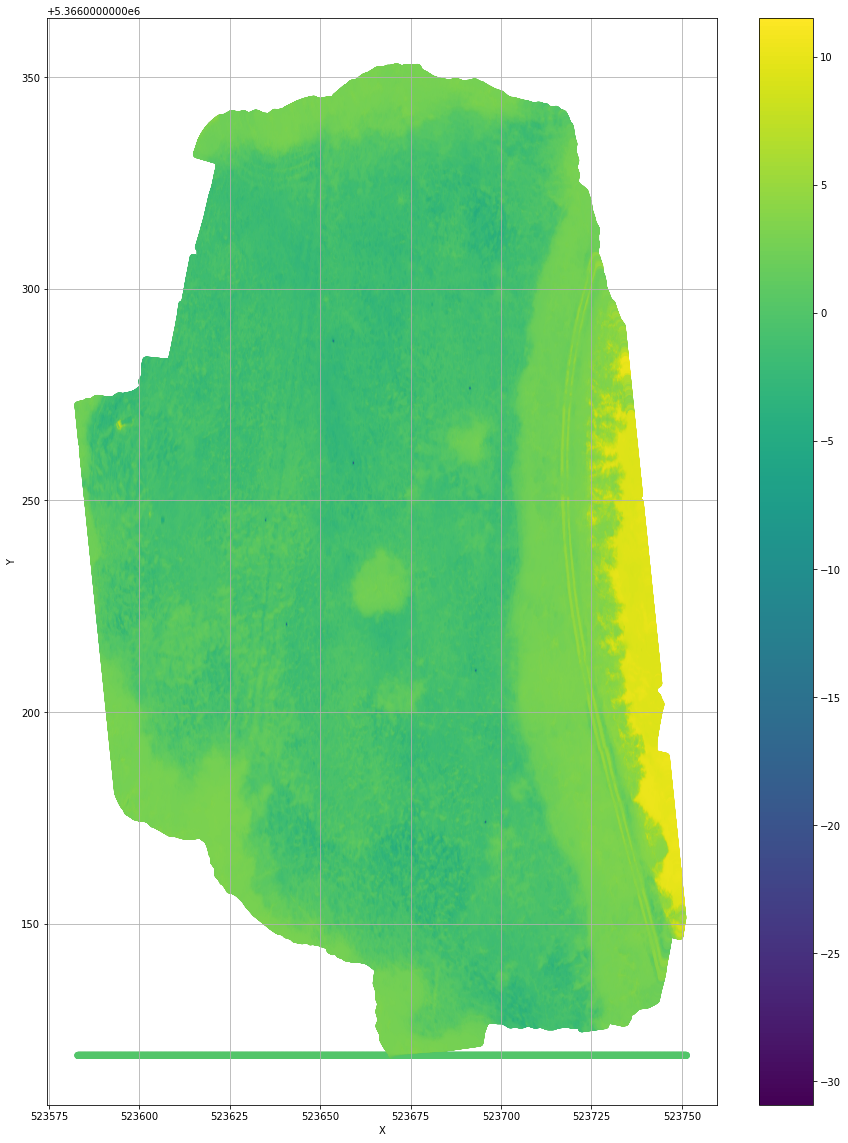

In [7]:
# On check les matrices crées, prend du temps à zaper si on s'en fout
fig,ax=plt.subplots(1,1, figsize = (15,20))
img0 = ax.scatter(X,Y,c = Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
fig.colorbar(img0, ax=ax)

## Calcul du Variogram 

In [ ]:
direction = [0]

dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

 ii : 0 / 10169525
 ii : 1 / 10169525
 ii : 2 / 10169525
 ii : 3 / 10169525
 ii : 4 / 10169525
 ii : 5 / 10169525
 ii : 6 / 10169525
 ii : 7 / 10169525
 ii : 8 / 10169525
 ii : 9 / 10169525
 ii : 10 / 10169525
 ii : 11 / 10169525
 ii : 12 / 10169525
 ii : 13 / 10169525
 ii : 14 / 10169525
 ii : 15 / 10169525
 ii : 16 / 10169525
 ii : 17 / 10169525
 ii : 18 / 10169525
 ii : 19 / 10169525
 ii : 20 / 10169525
 ii : 21 / 10169525
 ii : 22 / 10169525
 ii : 23 / 10169525
 ii : 24 / 10169525
 ii : 25 / 10169525
 ii : 26 / 10169525
 ii : 27 / 10169525
 ii : 28 / 10169525
 ii : 29 / 10169525
 ii : 30 / 10169525
 ii : 31 / 10169525
 ii : 32 / 10169525
 ii : 33 / 10169525
 ii : 34 / 10169525
 ii : 35 / 10169525
 ii : 36 / 10169525
 ii : 37 / 10169525
 ii : 38 / 10169525
 ii : 39 / 10169525
 ii : 40 / 10169525
 ii : 41 / 10169525
 ii : 42 / 10169525
 ii : 43 / 10169525
 ii : 44 / 10169525
 ii : 45 / 10169525
 ii : 46 / 10169525
 ii : 47 / 10169525
 ii : 48 / 10169525
 ii : 49 / 10169525
 ii : 50 /

 ii : 397 / 10169525
 ii : 398 / 10169525
 ii : 399 / 10169525
 ii : 400 / 10169525
 ii : 401 / 10169525
 ii : 402 / 10169525
 ii : 403 / 10169525
 ii : 404 / 10169525
 ii : 405 / 10169525
 ii : 406 / 10169525
 ii : 407 / 10169525
 ii : 408 / 10169525
 ii : 409 / 10169525
 ii : 410 / 10169525
 ii : 411 / 10169525
 ii : 412 / 10169525
 ii : 413 / 10169525
 ii : 414 / 10169525
 ii : 415 / 10169525
 ii : 416 / 10169525
 ii : 417 / 10169525
 ii : 418 / 10169525
 ii : 419 / 10169525
 ii : 420 / 10169525
 ii : 421 / 10169525
 ii : 422 / 10169525
 ii : 423 / 10169525
 ii : 424 / 10169525
 ii : 425 / 10169525
 ii : 426 / 10169525
 ii : 427 / 10169525
 ii : 428 / 10169525
 ii : 429 / 10169525
 ii : 430 / 10169525
 ii : 431 / 10169525
 ii : 432 / 10169525
 ii : 433 / 10169525
 ii : 434 / 10169525
 ii : 435 / 10169525
 ii : 436 / 10169525
 ii : 437 / 10169525
 ii : 438 / 10169525
 ii : 439 / 10169525
 ii : 440 / 10169525
 ii : 441 / 10169525
 ii : 442 / 10169525
 ii : 443 / 10169525
 ii : 444 / 1

 ii : 792 / 10169525
 ii : 793 / 10169525
 ii : 794 / 10169525
 ii : 795 / 10169525
 ii : 796 / 10169525
 ii : 797 / 10169525
 ii : 798 / 10169525
 ii : 799 / 10169525
 ii : 800 / 10169525
 ii : 801 / 10169525
 ii : 802 / 10169525
 ii : 803 / 10169525
 ii : 804 / 10169525
 ii : 805 / 10169525
 ii : 806 / 10169525
 ii : 807 / 10169525
 ii : 808 / 10169525
 ii : 809 / 10169525
 ii : 810 / 10169525
 ii : 811 / 10169525
 ii : 812 / 10169525
 ii : 813 / 10169525
 ii : 814 / 10169525
 ii : 815 / 10169525
 ii : 816 / 10169525
 ii : 817 / 10169525
 ii : 818 / 10169525
 ii : 819 / 10169525
 ii : 820 / 10169525
 ii : 821 / 10169525
 ii : 822 / 10169525
 ii : 823 / 10169525
 ii : 824 / 10169525
 ii : 825 / 10169525
 ii : 826 / 10169525
 ii : 827 / 10169525
 ii : 828 / 10169525
 ii : 829 / 10169525
 ii : 830 / 10169525
 ii : 831 / 10169525
 ii : 832 / 10169525
 ii : 833 / 10169525
 ii : 834 / 10169525
 ii : 835 / 10169525
 ii : 836 / 10169525
 ii : 837 / 10169525
 ii : 838 / 10169525
 ii : 839 / 1

 ii : 1177 / 10169525
 ii : 1178 / 10169525
 ii : 1179 / 10169525
 ii : 1180 / 10169525
 ii : 1181 / 10169525
 ii : 1182 / 10169525
 ii : 1183 / 10169525
 ii : 1184 / 10169525
 ii : 1185 / 10169525
 ii : 1186 / 10169525
 ii : 1187 / 10169525
 ii : 1188 / 10169525
 ii : 1189 / 10169525
 ii : 1190 / 10169525
 ii : 1191 / 10169525
 ii : 1192 / 10169525
 ii : 1193 / 10169525
 ii : 1194 / 10169525
 ii : 1195 / 10169525
 ii : 1196 / 10169525
 ii : 1197 / 10169525
 ii : 1198 / 10169525
 ii : 1199 / 10169525
 ii : 1200 / 10169525
 ii : 1201 / 10169525
 ii : 1202 / 10169525
 ii : 1203 / 10169525
 ii : 1204 / 10169525
 ii : 1205 / 10169525
 ii : 1206 / 10169525
 ii : 1207 / 10169525
 ii : 1208 / 10169525
 ii : 1209 / 10169525
 ii : 1210 / 10169525
 ii : 1211 / 10169525
 ii : 1212 / 10169525
 ii : 1213 / 10169525
 ii : 1214 / 10169525
 ii : 1215 / 10169525
 ii : 1216 / 10169525
 ii : 1217 / 10169525
 ii : 1218 / 10169525
 ii : 1219 / 10169525
 ii : 1220 / 10169525
 ii : 1221 / 10169525
 ii : 1222

## Importation des données de Température (Z)

#### Données de Température le 14-04-2019 07:00:00

In [43]:
date_1='2019-04-14 06:00:00'
date_2='2019-04-14 18:30:00'
dict_temp_sensor = dict_temp_sensor_function(date_1,date_2)
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Primary = reading_gps_file(filename_Sensor_txt)
Primary

completed : S1
completed : S10
completed : S2
completed : S3-AIR
completed : S4
completed : S5
completed : S6
completed : S7
completed : S8
completed : S9


In [62]:
Primary['T4'] = 0
for sensor in dict_temp_sensor :
    
    value = dict_temp_sensor[sensor]['T4'].loc[dict_temp_sensor[sensor]["Time"] == '2019-04-14 07:00:00']
    Primary['T4'].loc[Primary["SensorName"] == sensor] = value.values
    

C:\Users\Alexandre\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [63]:
Primary

,SensorName,x,y,T4
0,S10,523628.71,5366296.81,3.543
1,S1,523654.74,5366287.75,2.552
2,S9,523692.47,5366276.57,2.815
3,S2,523660.22,5366258.91,4.046
4,S4,523636.075,5366245.545,4.704
5,S5,523641.825,5366220.67,0.228
6,S8,523649.33,5366188.02,2.232
7,S7,523696.655,5366174.0,2.496
8,S6,523694.05,5366209.93,2.633
9,S3-AIR,523624.949,5366313.764,-5.905


In [64]:
X = Primary["x"].astype(float).values
Y = Primary["y"].astype(float).values
Z = Primary["T4"].astype(float).values
print("X :", len(X))
print("Y :", len(Y))
print("Z :", len(Z))

X : 10
Y : 10
Z : 10


max x : 523696.655  	 Distance maximale retenue : 35.853000000002794
nlag : 35


In [78]:
dist = 0
for i in range(0,len(X)) :
    print('i :')
    for j in range (0,len(X)) :
        x = X[i] - X[j]
        y = Y[i] - Y[j]
        dist_temp = np.sqrt((x)**2+(y)**2)
        print(dist_temp) # distance euclidienne
        if dist_temp > dist :
            dist = dist_temp
print("distnace maximale retenue:",dist / 2)

i :
0.0
27.561649079672264
66.89540492414343
49.287829126008
51.79134531913114
77.26126341802015
110.72690955683679
140.35248171977688
108.70809537461467
17.366152050138716
i :
27.561649079672264
0.0
39.35156032474355
29.356021528660875
46.148068757051
68.31195814064661
99.87662889830077
121.22676983654692
87.18502451709354
39.5503713891614
i :
66.89540492414343
39.35156032474355
0.0
36.76871088310363
64.36572573985825
75.43027260349548
98.49955380674642
102.65534143463556
66.6587278612448
77.0874767845153
i :
49.287829126008
29.356021528660875
36.76871088310363
0.0
27.59717829786341
42.43434487553258
71.72157416066344
92.39706340046406
59.52738277502963
65.21506541457666
i :
51.79134531913114
46.148068757051
64.36572573985825
27.59717829786341
0.0
25.53092487553085
59.03236951065901
93.74765823737313
68.04064116403681
69.12032868171916
i :
77.26126341802015
68.31195814064661
75.43027260349548
42.43434487553258
25.53092487553085
0.0
33.50145556575708
72.00290133039664
53.3178977924146


In [82]:
L = dist * 1/2
print("max x :", max(X), " \t Distance maximale retenue :",L)
w = 2.5 # width, taille des lags
print("nlag :" , np.int(np.fix(L/w)))

max x : 523696.655  	 Distance maximale retenue : 78.54254600552747
nlag : 31


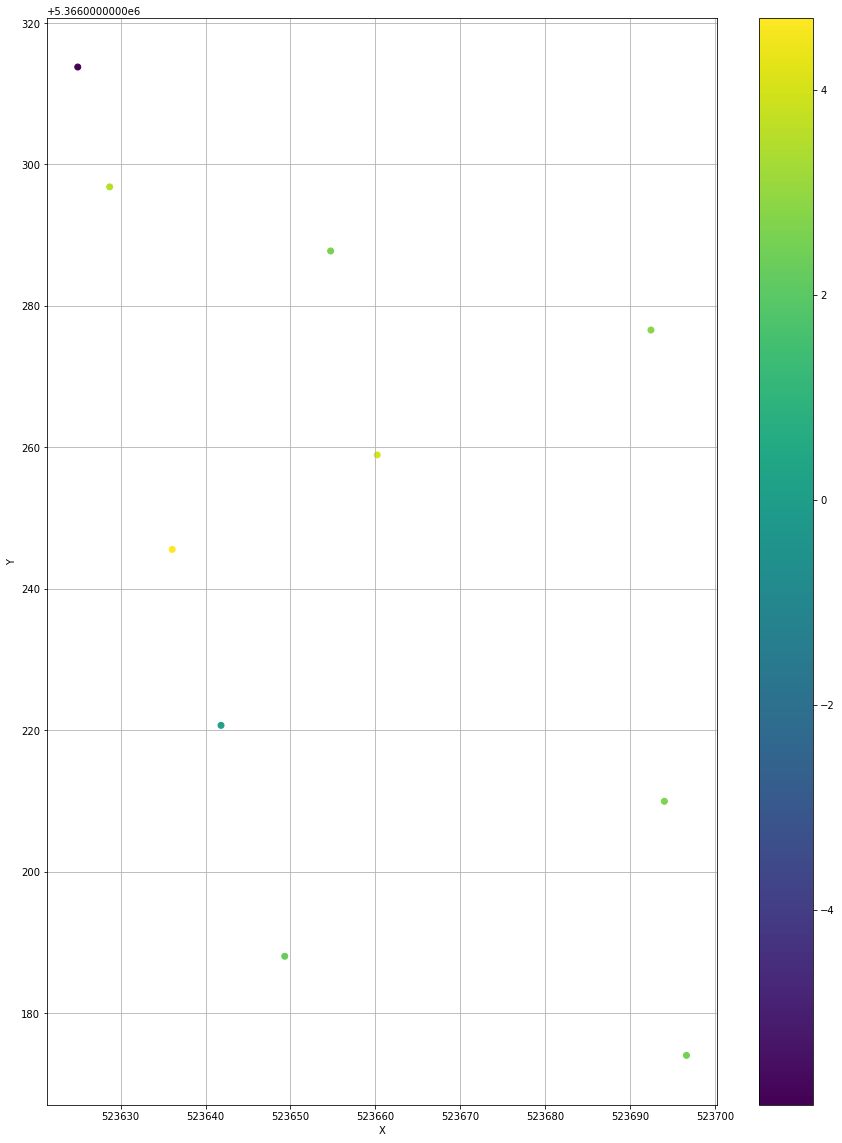

In [83]:
# On check les matrices crées, prend du temps à zaper si on s'en fout
fig,ax=plt.subplots(1,1, figsize = (15,20))
img0 = ax.scatter(X,Y,c = Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
fig.colorbar(img0, ax=ax)

In [109]:
direction = [0,45,90,135]
angle_tolerance = 360
dist, counts, gam = {}, {}, {}

for Dir in direction :
    st1 = timeit.default_timer()
    dist[Dir], counts[Dir], gam[Dir] = alternate_variogram_compiled(X,Y,Z,w,L,Dir,angle_tolerance)
    print("direction done :", Dir)
    st2 = timeit.default_timer()
    print("RUN TIME : {0}".format(st2-st1))

 ii : 0 / 10
 ii : 1 / 10
 ii : 2 / 10
 ii : 3 / 10
 ii : 4 / 10
 ii : 5 / 10
 ii : 6 / 10
 ii : 7 / 10
 ii : 8 / 10
 ii : 9 / 10
direction done : 0
RUN TIME : 0.011574400000426976
 ii : 0 / 10
 ii : 1 / 10
 ii : 2 / 10
 ii : 3 / 10
 ii : 4 / 10
 ii : 5 / 10
 ii : 6 / 10
 ii : 7 / 10
 ii : 8 / 10
 ii : 9 / 10
direction done : 45
RUN TIME : 0.012843700000303215
 ii : 0 / 10
 ii : 1 / 10
 ii : 2 / 10
 ii : 3 / 10
 ii : 4 / 10
 ii : 5 / 10
 ii : 6 / 10
 ii : 7 / 10
 ii : 8 / 10
 ii : 9 / 10
direction done : 90
RUN TIME : 0.011259500000051048
 ii : 0 / 10
 ii : 1 / 10
 ii : 2 / 10
 ii : 3 / 10
 ii : 4 / 10
 ii : 5 / 10
 ii : 6 / 10
 ii : 7 / 10
 ii : 8 / 10
 ii : 9 / 10
direction done : 135
RUN TIME : 0.011633699999947567


<ipython-input-85-c4eaf4e42d1d>:53: RuntimeWarning: invalid value encountered in true_divide
  gam = np.divide(dev,2*counts)


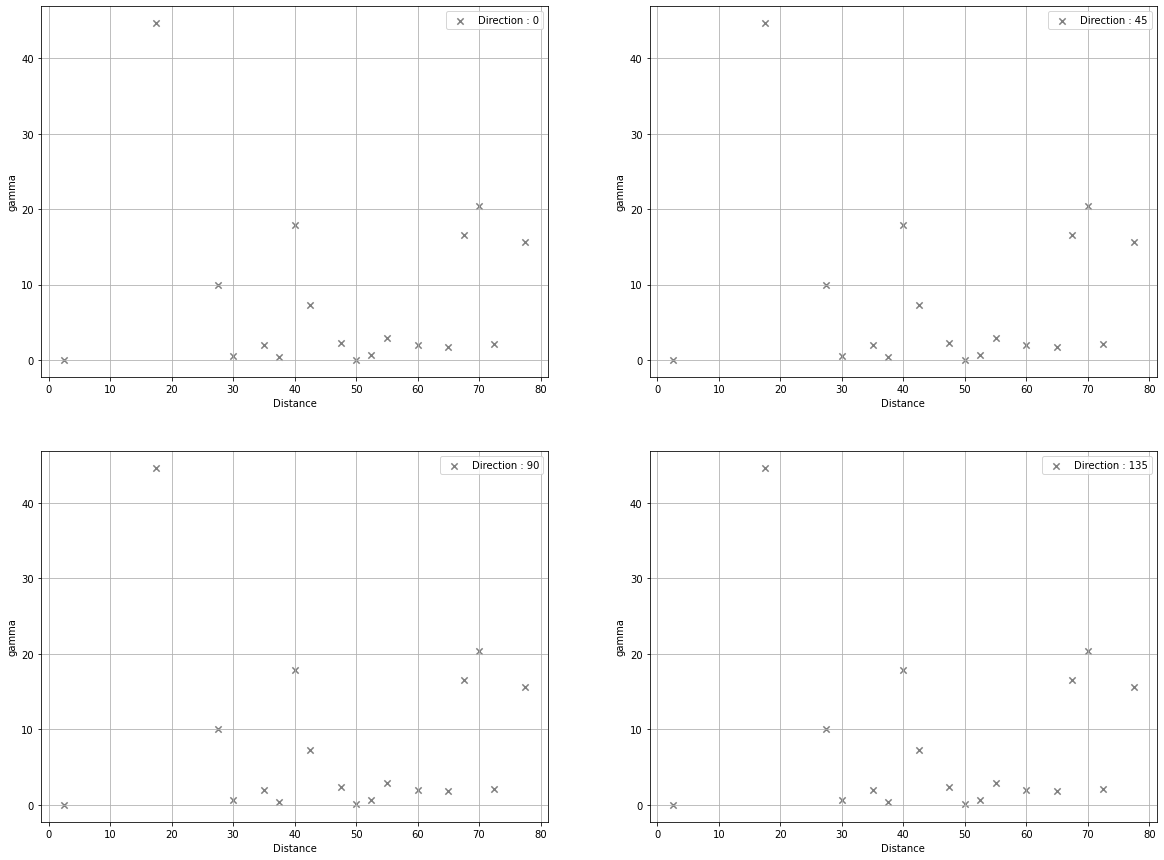

In [111]:
plt.close('all')
fig,ax=plt.subplots(2,2,figsize = (20,15))
ii = 0
jj = 0
for Dir in direction : 
    dist_dir = dist[Dir]
    gam_dir = gam[Dir]
    ax[ii,jj].scatter(dist_dir,gam_dir,40,marker = 'x',color = "grey",label = str("Direction : " + str(Dir)))
    ax[ii,jj].set_xlabel('Distance')
    ax[ii,jj].set_ylabel('gamma')
    ax[ii,jj].grid()
    ax[ii,jj].legend()
    #ax[ii,jj].set_ylim([0,1])
    jj += 1
    if jj == 2 :
        ii += 1
        jj = 0

In [115]:
counts

{0: array([10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  6.,  0.,
         2.,  4.,  4.,  2.,  0.,  2.,  6.,  2.,  2.,  0.,  4.,  0.,  2.,
         6.,  6.,  4.,  0.,  6.]),
 45: array([10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  6.,  0.,
         2.,  4.,  4.,  2.,  0.,  2.,  6.,  2.,  2.,  0.,  4.,  0.,  2.,
         6.,  6.,  4.,  0.,  6.]),
 90: array([10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  6.,  0.,
         2.,  4.,  4.,  2.,  0.,  2.,  6.,  2.,  2.,  0.,  4.,  0.,  2.,
         6.,  6.,  4.,  0.,  6.]),
 135: array([10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  6.,  0.,
         2.,  4.,  4.,  2.,  0.,  2.,  6.,  2.,  2.,  0.,  4.,  0.,  2.,
         6.,  6.,  4.,  0.,  6.])}

In [97]:
INDICE = 2 # Permet de choisir une valeur
Dir    = 45  # Direction en degrée 
angle_tolerance = 360
index_dict = direction_angle_test(X,Y,Z,INDICE,w,L,Dir,angle_tolerance)

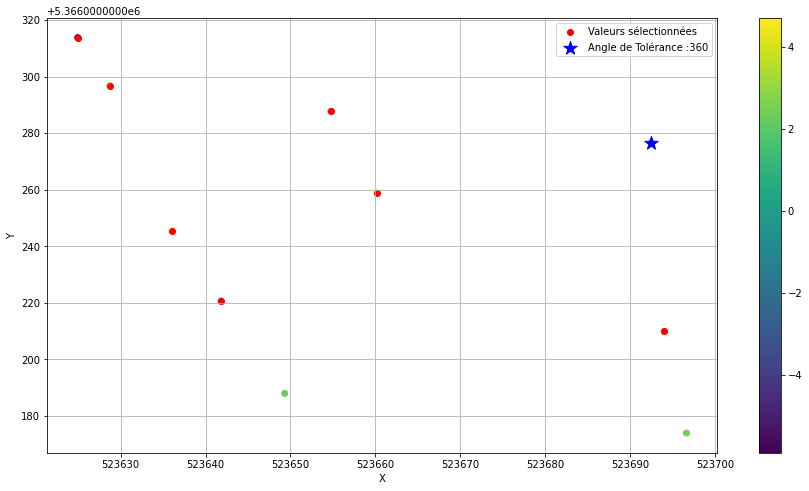

In [114]:
index = index_dict[INDICE]
LABEL = str("Angle de Tolérance :" + str(angle_tolerance) )

fig,ax=plt.subplots(1,1, figsize = (15,8))
img0 = ax.scatter(X,Y,c = Z)
X_value,Y_value = [],[]
for ii in index :
    X_value.append(X[ii])
    Y_value.append(Y[ii])

ax.scatter(X_value,Y_value,c = 'r', label = "Valeurs sélectionnées")
ax.scatter(X[INDICE],Y[INDICE],c = 'blue',marker = '*', s = 200,label = LABEL)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()
ax.legend()
fig.colorbar(img0, ax=ax)